# Detect fake tweet with logistic regression


# Importing library


In [1]:
!pip install textstat

     |████████████████████████████████| 99 kB 744 kB/s 
     |████████████████████████████████| 1.9 MB 2.9 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
#nltk.download('wordnet')
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
import sklearn as sk #this is the most popular library for statistics and machine learning
import matplotlib.pyplot as plt 
import os
import itertools
import collections
import re
import textstat
import networkx
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
from sklearn import metrics
import string
from collections import Counter


## Reading data and summarizing

In [3]:
df = pd.read_csv('../input/fakenews/tweets_labeled.csv')
df.head(10)

,tweet_id,text,label
0,1161040537207463936,'RT @SenJeffMerkley: The Endangered Species Ac...,1
1,1176360756239118342,'RT @LindseyGrahamSC: Interesting concept -- i...,1
2,1099036648573145088,'RT @RealJamesWoods: #BuildTheWall #DeportThem...,0
3,1092915693203480577,'RT @PatriotJackiB: Why would the MEXICAN GOV’...,0
4,1149038450668187654,'RT @TheOnion: Sweden Announces Plan To Get 10...,0
5,1175456815674343424,'RT @kcResister: Warren: 'Congress is complici...,1
6,1180809117310623744,'RT @ShimonPro: A dozen current and former sta...,1
7,1179840318935576578,'RT @samstein: This is a bombshell that isn’t ...,1
8,1081722778125062144,'Planned Parenthood Erects Billboards Urging W...,0
9,1158761795739217921,'https://t.co/MvrznF1fWVWhoever obstructing th...,1


In [4]:
df.shape

(225405, 3)

In [5]:
df = df[['text','label']]

Remove duplicates:

In [6]:
df = df[df.duplicated(['text'], keep=False)]
df.shape

(193556, 2)

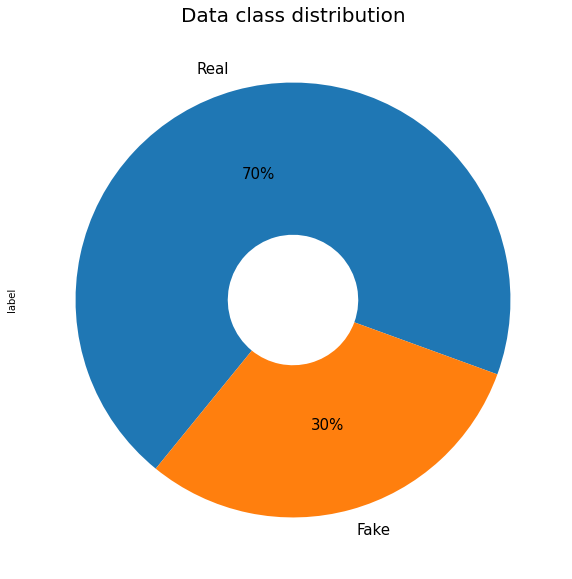

In [7]:
plt.figure(figsize=(30,10))
plt.title('Data class distribution', fontsize=20)
df.label.value_counts().plot(kind='pie', labels=['Real', 'Fake'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

## Extract Features

In [8]:
def contains_hashtag(tweet):
    if '#' in tweet:
        return 1
    else:
        return 0

In [9]:
df['contains_hashtag'] = df['text'].apply(lambda x: contains_hashtag(x))

In [10]:
def count_hashtag(tweet):
    return tweet.count('#')

In [11]:
df['count_hashtag'] = df['text'].apply(lambda x: count_hashtag(x))

In [12]:
def contains_link(tweet):
    #if a tweet contains a link (has 'https://' in it) return 1 (true) otherwise return 0 (false)
    if 'https://' in tweet:
        return 1
    else:
        return 0

In [13]:
df['contains_link'] = df['text'].apply(lambda x: contains_link(x))

In [14]:
def count_link(tweet):
    return tweet.count('https://')

In [15]:
df['count_link'] = df['text'].apply(lambda x: contains_link(x))

In [16]:
def contains_mention(tweet):
    if '@' in tweet:
        return 1
    else:
        return 0

In [17]:
df['contains_mention'] = df['text'].apply(lambda x: contains_mention(x))

In [18]:
def count_mention(tweet):
    return tweet.count('@')

In [19]:
df['count_mention'] = df['text'].apply(lambda x: count_mention(x))

In [20]:
def is_retweet(tweet):
    regexp = re.compile('(RT @.*: )')
    if regexp.search(tweet):
        return 1
    else:
        return 0

In [21]:
df['is_retweet'] = df['text'].apply(lambda x: is_retweet(x))

In [22]:
def count_3dots(tweet):
    return tweet.count('…') + tweet.count('...')

In [23]:
df['count_3dots'] = df['text'].apply(lambda x: count_3dots(x))

In [24]:
def count_capital_letters(tweet):
    return sum(1 for c in tweet if c.isupper())

In [25]:
df['count_capital_letters'] = df['text'].apply(lambda x: count_capital_letters(x))

In [26]:
def count_capital_letters_to_length(tweet):
    return sum(1 for c in tweet if c.isupper()) / len(tweet)

In [27]:
df['count_capital_letters_to_length'] = df['text'].apply(lambda x: count_capital_letters_to_length(x))

In [28]:
stop_words = set(stopwords.words('english'))
def count_stop_words(tweet):
    word_tokens = word_tokenize(tweet)
    return sum(1 for w in word_tokens if w in stop_words)

In [29]:
df['count_stop_words'] = df['text'].apply(lambda x: count_stop_words(x))

In [30]:
def count_special_chars(tweet):
    word_tokens = word_tokenize(tweet)
    return sum(1 for w in word_tokens if w in stop_words)

In [31]:
df['count_special_chars'] = df['text'].apply(lambda x: count_special_chars(x))

In [32]:
def count_special_chars(tweet):
    count = 0
    for i in range(0, len(tweet)):
    # len(string) function to count the 
    # number of characters in given string.      
        #.isalpha() function checks whether character 
        #is alphabet or not.
        if (tweet[i].isalpha()):
            continue
        #.isdigit() function checks whether character 
        #is a number or not.
        elif (tweet[i].isdigit()):
            continue
        else:
            count += 1
            
    return count

In [33]:
df['count_special_chars'] = df['text'].apply(lambda x: count_special_chars(x))

In [34]:
def count_digits(tweet): 
    count = 0
    for i in range(0, len(tweet)):
        if (tweet[i].isdigit()):
            count += 1
    return count

In [35]:
df['count_digits'] = df['text'].apply(lambda x: count_digits(x))

In [36]:
def count_alphabets(tweet): 
    count = 0
    for i in range(0, len(tweet)):
        if (tweet[i].isalpha()):
            count += 1
    return count

In [37]:
df['count_alphabets'] = df['text'].apply(lambda x: count_alphabets(x))

Before cleaning (bc)

In [38]:
df['bc_length'] = df['text'].apply(lambda x: len(x))
df['bc_words_count'] = df['text'].apply(lambda x: len(x.split()))
df['bc_words_average_length'] = df['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

In [39]:
# Remove emojies from code
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

In [40]:
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

In [41]:
df['count_open_parentheses'] = df['text'].apply(lambda x: x.count('('))
df['count_close_parentheses'] = df['text'].apply(lambda x: x.count(')'))
df['count_exclamation_mark'] = df['text'].apply(lambda x: x.count('!'))
df['count_question_mark'] = df['text'].apply(lambda x: x.count('?'))
df['count_|'] = df['text'].apply(lambda x: x.count('|'))
df['count_percentage_sign'] = df['text'].apply(lambda x: x.count('%'))
df['count_comma'] = df['text'].apply(lambda x: x.count(','))
df['count_plus'] = df['text'].apply(lambda x: x.count('+'))
df['count_minus'] = df['text'].apply(lambda x: x.count('-'))

## Cleaning

In [42]:
def clean_word():
    word = df['text'].str.replace(r'RT\s', '')
    word = word.str.replace("}", "")
    word = word.str.replace("{", "")
    word = word.str.replace("-", "")
    word = word.str.replace("--", "")
    word = word.str.replace("|", "")
    word = word.str.replace("¦", "")
    word = word.str.replace(",", "")
    word = word.str.replace(".", "")
    word = word.str.replace(":", "")
    word = word.str.replace("?", "")
    word = word.str.replace("#", "")
    word = word.str.replace("(", "")
    word = word.str.replace(")", "")
    word = word.str.replace("!", "")
    word = word.str.replace(";", "")
    word = word.str.replace("&", "")
    word = word.str.replace("'", "")
    word = word.str.replace('—', "")
    word = word.str.replace("i'm", "i am")
    word = word.str.replace("it's", "it is")
    word = word.str.replace(r'RT\s', '')
    word = word.str.replace(r'@\S*?\s', '')
    word = word.str.replace(r'@\S*?$', '')
    word = word.str.replace(r'https\S*?\s', ' ')  
    word = word.str.replace(r'https\S*?$', '')
    word = word.str.replace('\'', '')
    word = word.str.replace(r'…', '')
    word = word.str.replace(r'\s$', '')
    df['text'] = word 

In [43]:
clean_word()

In [44]:
stop = stopwords.words('english')

def words_only_count(tweet):
    words = tweet.split()
    words_only = [word for word in words if word not in stop and
              not word.startswith(('#', '@'))]
    return len(words_only)

In [45]:
df['words_only_count'] = df['text'].apply(lambda x: words_only_count(x))

## Sentiment Features: polarity and subjectivity

We take subjectivity and polarity of the each text as a feature.

In [46]:
from textblob import TextBlob
opinion = TextBlob("That great because that is!")
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [47]:
df['is_positive'] = df['polarity'].apply(lambda x: 1 if x > 0 else 0)
df['is_negative'] = df['polarity'].apply(lambda x: 1 if x < 0 else 0)
df['is_neutral'] = df['polarity'].apply(lambda x: 1 if x == 0 else 0)

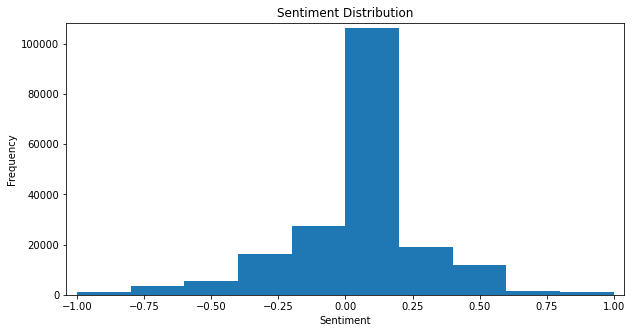

In [48]:
plt.figure(figsize=(10,5))
plt.margins(0.02)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.hist(df['polarity'])
plt.title('Sentiment Distribution')
plt.show()

## POS Features

In [49]:
from textblob import TextBlob
from textblob.taggers import NLTKTagger
nltk_tagger = NLTKTagger()

for i, row in df.iterrows():
    blob = TextBlob(row["text"], pos_tagger=nltk_tagger)
    for elem1 in blob.pos_tags:
        count = 0
        for elem2 in blob.pos_tags:
            if elem1[1] == elem2[1]:
                count += 1
        df.at[i,'COUNT_'+elem1[1]] = count

## Word Clouds

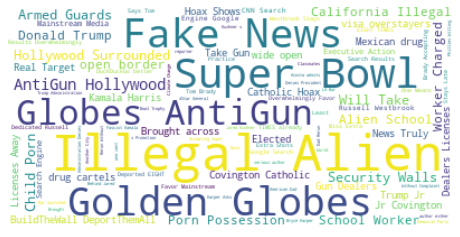

In [50]:
from wordcloud import WordCloud

text = " ".join([x for x in df[df['label'] == 0].text])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

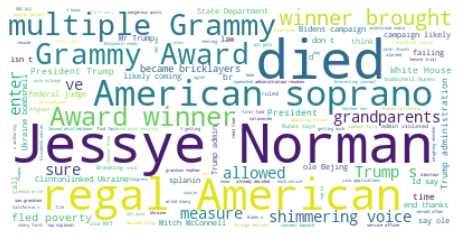

In [51]:
text = " ".join([x for x in df[df['label'] == 1].text])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Frequency

trump :  13867
ukraine :  6514
president :  5004
house :  3895
whistleblower :  3462
new :  3300
trumps :  2611
news :  2581
american :  2569
time :  2323
says :  2322
award :  2194
multiple :  2165
brought :  2119
died :  2095
jessye :  2083
norman :  2083
soprano :  2039
regal :  2036
voice :  2033


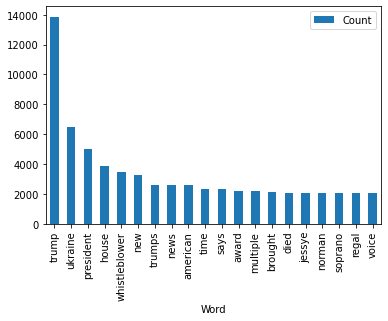

In [52]:
import collections
stop_words = set(stopwords.words('english'))
text = " ".join([x for x in df[df['label'] == 1].text])

wordcount = {}
for word in text.lower().split():
    if word not in stop_words and len(word) > 2:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
            
n_print = 20

word_counter = collections.Counter(wordcount)

for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
    

lst = word_counter.most_common(n_print)
dftemp = pd.DataFrame(lst, columns = ['Word', 'Count'])
dftemp.plot.bar(x='Word',y='Count')

Add 20 features for most frequent words

In [53]:
for elem in lst:
    df['count_positive_' + elem[0]] = df['text'].apply(lambda x: x.lower().count(elem[0]))

In [54]:
def check_contains_freq_words(text, words):
    for word in words:
        if word in text:
            return 1
    return 0

In [55]:
positive_words = []
for elem in lst:
    positive_words.append(elem[0])
    
df['has_positive_frequent_words'] = df['text'].apply(lambda x: check_contains_freq_words(x, positive_words))

trump :  11849
illegal :  7931
brought :  6564
search :  5930
one :  5806
google :  5236
california :  4996
breitbart :  4910
media :  4711
he’s :  4686
charged :  4515
alien :  4502
news :  4455
new :  4400
miss :  4348
child :  4272
gun :  4255
border :  4232
super :  4164
bowl :  4164


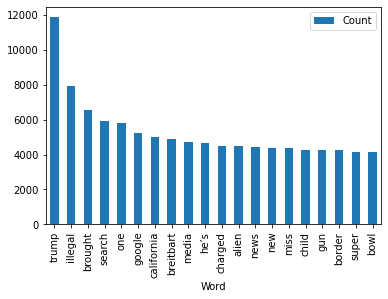

In [56]:
import collections
stop_words = set(stopwords.words('english'))
text = " ".join([x for x in df[df['label'] == 0].text])

wordcount = {}
for word in text.lower().split():
    if word not in stop_words and len(word) > 2:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
            
n_print = 20

word_counter = collections.Counter(wordcount)

for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
    

lst = word_counter.most_common(n_print)
dftemp = pd.DataFrame(lst, columns = ['Word', 'Count'])
dftemp.plot.bar(x='Word',y='Count')

In [57]:
for elem in lst:
    df['count_negative_' + elem[0]] = df['text'].apply(lambda x: x.lower().count(elem[0]))

In [58]:
negative_words = []
for elem in lst:
    negative_words.append(elem[0])
    
df['has_negative_frequent_words'] = df['text'].apply(lambda x: check_contains_freq_words(x, negative_words))

## Bigrams

In [59]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

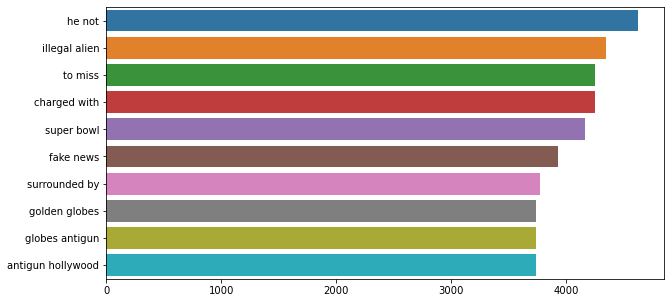

In [60]:
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(df[df['label'] == 0]['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [61]:
for elem in top_tweet_bigrams:
    df['count_bigrams_negative_' + elem[0]] = df['text'].apply(lambda x: x.lower().count(elem[0]))

In [62]:
negative_bigrams = []
for elem in top_tweet_bigrams:
    negative_bigrams.append(elem[0])
    
df['has_negative_frequent_bigrams'] = df['text'].apply(lambda x: check_contains_freq_words(x, negative_bigrams))

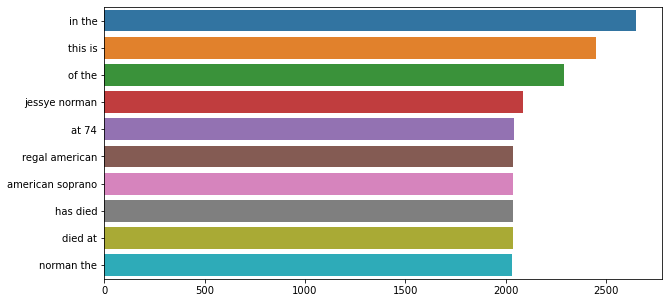

In [63]:
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(df[df['label'] == 1]['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [64]:
for elem in top_tweet_bigrams:
    df['count_bigrams_positive_' + elem[0]] = df['text'].apply(lambda x: x.lower().count(elem[0]))

In [65]:
positive_bigrams = []
for elem in top_tweet_bigrams:
    positive_bigrams.append(elem[0])
    
df['has_positive_frequent_bigrams'] = df['text'].apply(lambda x: check_contains_freq_words(x, positive_bigrams))

After cleaning (ac)

In [66]:
df['ac_length'] = df['text'].apply(lambda x: len(x))
df['ac_words_count'] = df['text'].apply(lambda x: len(x.split()))

In [67]:
df['readability'] = df['text'].apply(textstat.flesch_reading_ease)

List of all columns

In [68]:
list(df.columns)

['text',
 'label',
 'contains_hashtag',
 'count_hashtag',
 'contains_link',
 'count_link',
 'contains_mention',
 'count_mention',
 'is_retweet',
 'count_3dots',
 'count_capital_letters',
 'count_capital_letters_to_length',
 'count_stop_words',
 'count_special_chars',
 'count_digits',
 'count_alphabets',
 'bc_length',
 'bc_words_count',
 'bc_words_average_length',
 'count_open_parentheses',
 'count_close_parentheses',
 'count_exclamation_mark',
 'count_question_mark',
 'count_|',
 'count_percentage_sign',
 'count_comma',
 'count_plus',
 'count_minus',
 'words_only_count',
 'polarity',
 'subjectivity',
 'is_positive',
 'is_negative',
 'is_neutral',
 'COUNT_DT',
 'COUNT_NNP',
 'COUNT_VBD',
 'COUNT_NN',
 'COUNT_CC',
 'COUNT_VBN',
 'COUNT_IN',
 'COUNT_JJ',
 'COUNT_VBZ',
 'COUNT_TO',
 'COUNT_VBG',
 'COUNT_RB',
 'COUNT_VB',
 'COUNT_NNS',
 'COUNT_VBP',
 'COUNT_WRB',
 'COUNT_MD',
 'COUNT_WP',
 'COUNT_PRP',
 'COUNT_NNPS',
 'COUNT_CD',
 'COUNT_WDT',
 'COUNT_PRP$',
 'COUNT_JJR',
 'COUNT_RBR',
 'CO

In [69]:
print("Count of features:",(len(df.columns) - 2))

Count of features: 133


## Correlation between features and label

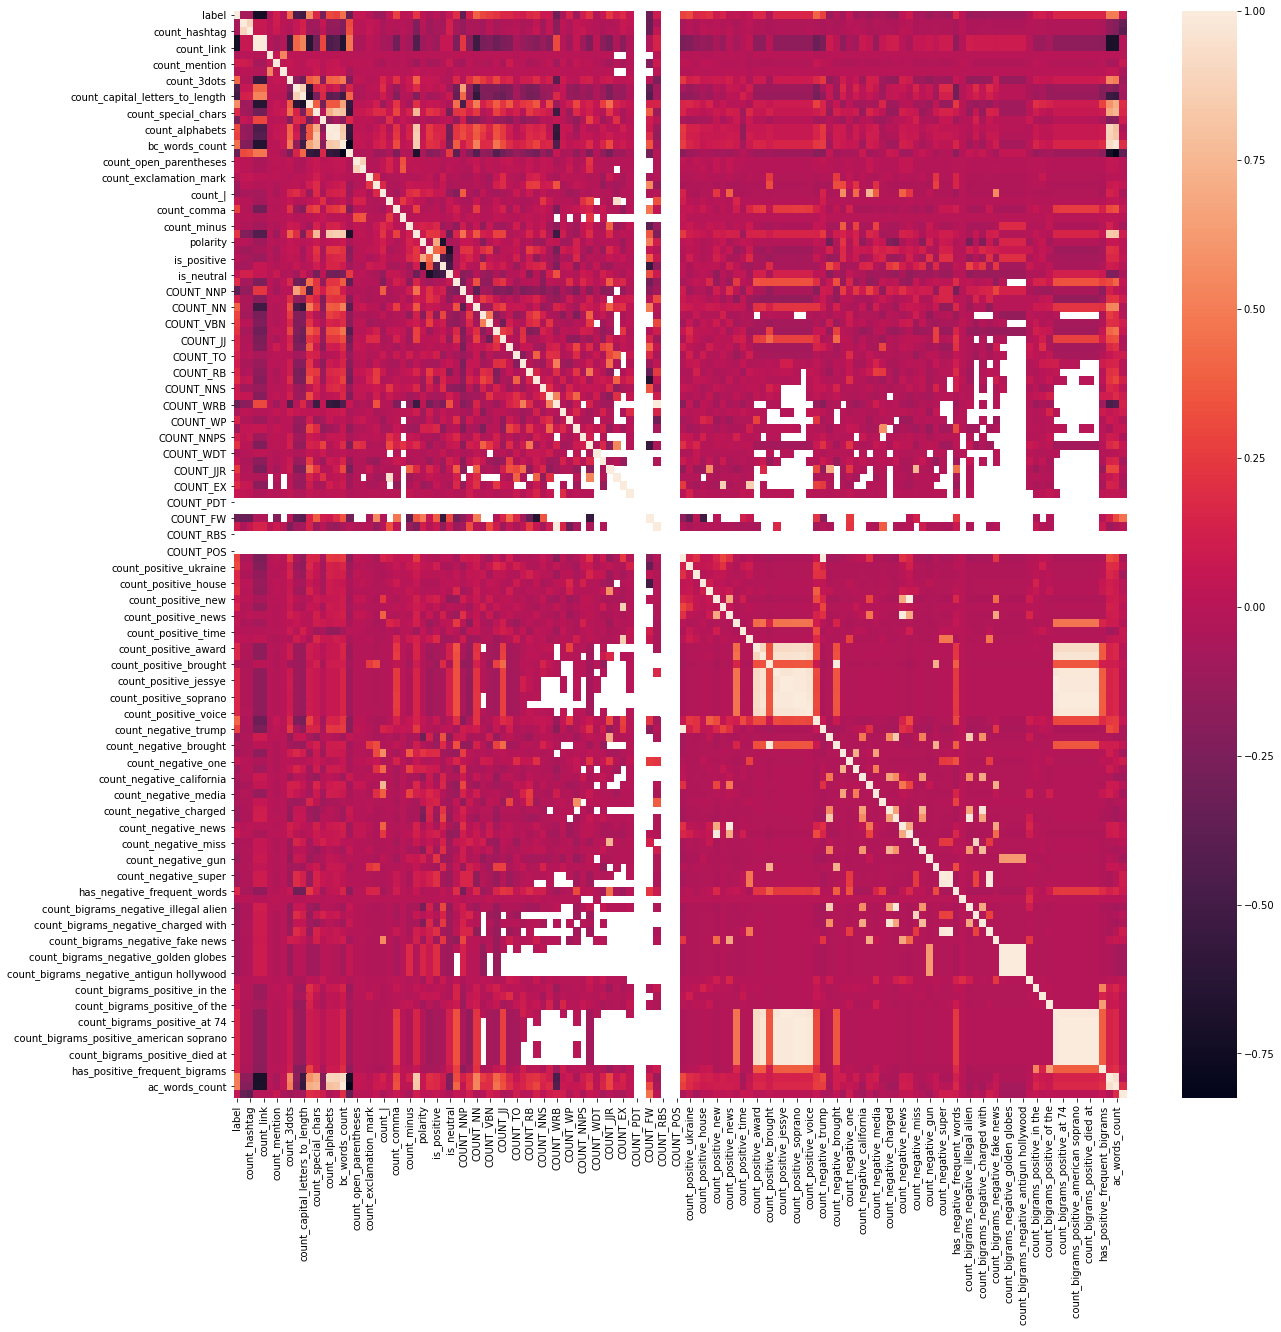

In [70]:
plt.figure(figsize=(20,20))
sns.heatmap(df.loc[:, ~df.columns.isin(['text'])].corr())

In [71]:
df = df.fillna(0)

# Modeling

reference: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

First we split the data to two sets. Test set and training set. 20% of data is for testing and 80% is for training.

In [72]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, ~df.columns.isin(['text', 'label'])], df[['label']], test_size=0.2, random_state=42)

Here we create our mode, we use the logistic regression model of sklearn package.

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

Train the data to fit to the training set.

In [74]:
pipe.fit(x_train, y_train.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [75]:
pipe.score(x_test, y_test)

0.9434283942963422

## Evaluation

Calculate the accuracy:

In [76]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of Logsitic Regression Classifier is: {(pipe.score(x_test, y_test))*100:.2f}%")

Validation Accuracy of Logsitic Regression Classifier is: 94.34%


Get the confusion matrix to see how our model worked on test set.

In [77]:
cm = metrics.confusion_matrix(y_test, pipe.predict(x_test))
print(cm)

[[26049   910]
 [ 1280 10473]]


Plot the confusion matrix:

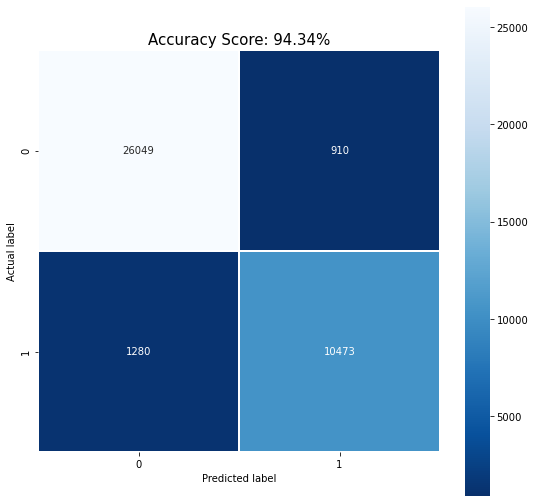

In [78]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Accuracy Score: {(pipe.score(x_test, y_test))*100:.2f}%'
plt.title(all_sample_title, size = 15);

Details of accuracy, recall, and f1-score:

In [79]:
print(metrics.classification_report(y_test, pipe.predict(x_test), target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     26959
           1       0.92      0.89      0.91     11753

    accuracy                           0.94     38712
   macro avg       0.94      0.93      0.93     38712
weighted avg       0.94      0.94      0.94     38712



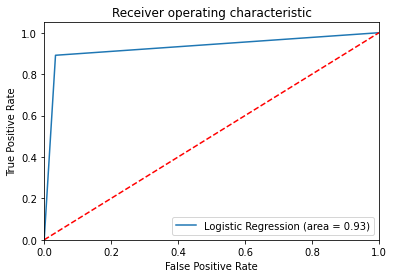

In [80]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, pipe.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict(x_test))

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [81]:
# The estimated coefficients will all be around 1:
print(pipe.coef_)

# Those values, however, will show that the second parameter
# is more influential
print(np.std(x_train, 0)*pipe.coef_)

AttributeError: 'Pipeline' object has no attribute 'coef_'